In [1]:
# Standard modules
import pickle as pkl
import numpy as np
from icecream import ic
# PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Modules from local files
from GNN_mol import GNN
from Dataset import XASDataset
from train import train_model
from test import test_model
from utils import plot_learning_curve

#### Import dataset

In [2]:
# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

In [3]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(319)
------------
Number of graphs: 319
Number of features: 15
Number of classes: 0

Data(x=[30, 15], edge_index=[2, 76], edge_attr=[76, 6], spectrum=[200], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')
------------
Number of nodes: 30
Number of edges: 76
Average node degree: 2.53
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
torch.save(dataset, './XASNet-data/mol_dataset.pt')

#### View data

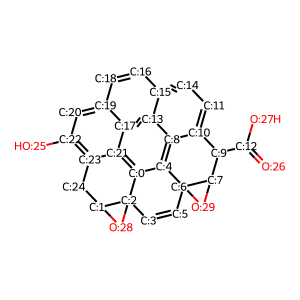

In [5]:
mol = Chem.MolFromSmiles(data.smiles)
mol

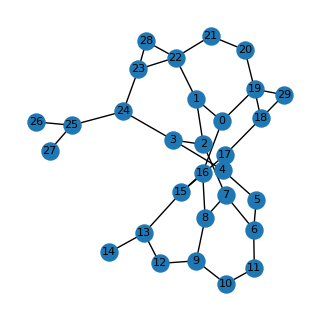

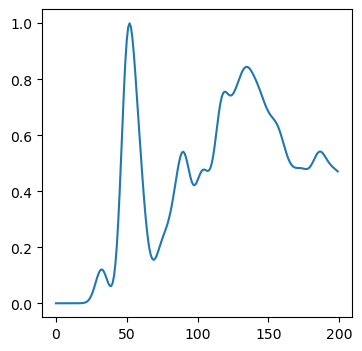

In [6]:
# Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(data.spectrum)

plt.show()

#### Split up dataset

In [7]:
# Split data into test, validation and test
train_dataset = dataset[0:252]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

# Pass into dataloader
test_loader = DataLoader(test_dataset, batch_size=39, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=28, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=252, shuffle=True)

print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 252
Length of validation data loader: 28
Length of testing data loader: 39


In [8]:
torch.save(test_dataset, './processed/test_dataset.pt')

#### Set neural network properties

In [9]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 500, 300, 200]
out_channels = [500, 300, 200, 200]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(10, 500)
      (1): GCNConv(500, 300)
      (2): GCNConv(300, 200)
      (3): GCNConv(200, 200)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2-3): 2 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=200, out_features=200, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [12]:
num_epochs = 500
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    loss = train_model(epoch, train_loader, model, device, optimizer)

    val_error = test_model(val_loader, model, device)

    scheduler.step(val_error)

    train_losses.append(loss)

    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}")

Epoch: 000, LR: 0.010000, TrainLoss: 0.2595091, ValLoss:0.262785, Best_ValLoss:0.262785
Epoch: 025, LR: 0.010000, TrainLoss: 0.0235016, ValLoss:0.072184, Best_ValLoss:0.072184
Epoch: 050, LR: 0.010000, TrainLoss: 0.0095180, ValLoss:0.013174, Best_ValLoss:0.013174
Epoch: 075, LR: 0.010000, TrainLoss: 0.0084642, ValLoss:0.010145, Best_ValLoss:0.010145
Epoch: 100, LR: 0.010000, TrainLoss: 0.0082902, ValLoss:0.009729, Best_ValLoss:0.009643
Epoch: 125, LR: 0.010000, TrainLoss: 0.0082113, ValLoss:0.009785, Best_ValLoss:0.009643
Epoch: 150, LR: 0.010000, TrainLoss: 0.0081804, ValLoss:0.009837, Best_ValLoss:0.009643
Epoch: 175, LR: 0.010000, TrainLoss: 0.0081581, ValLoss:0.009939, Best_ValLoss:0.009643
Epoch: 200, LR: 0.005000, TrainLoss: 0.0081410, ValLoss:0.009766, Best_ValLoss:0.009643
Epoch: 225, LR: 0.005000, TrainLoss: 0.0081317, ValLoss:0.009650, Best_ValLoss:0.009643
Epoch: 250, LR: 0.005000, TrainLoss: 0.0081229, ValLoss:0.009704, Best_ValLoss:0.009643
Epoch: 275, LR: 0.005000, TrainL

In [13]:
model_name = 'model_gnn_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

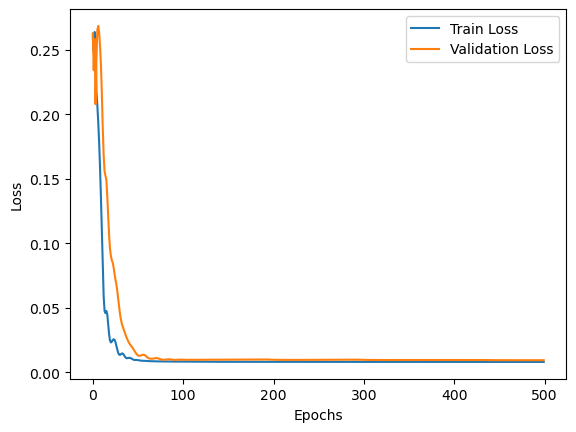

In [14]:
plot_learning_curve(num_epochs, train_losses, val_losses)